# Vision Transformer from scratch: training end to end

This notebook implements the Vision Transformer architecture described in the ViT paper "AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE" and trains it end to end.

ViT converts an image into a sequence of patch tokens, then applies a standard Transformer encoder.
If an image is split into $N$ patches and each patch token has dimension $D$, the token sequence has shape $[B, N+1, D]$ because we also prepend a learnable class token $[\mathrm{CLS}]$.


<img src="assets/vit_architecture.png" alt="VIT Architecture" width="900" height="600">


## Imports and device

We import PyTorch, torchvision for data, and matplotlib for visualization.
We also choose a compute device. Training a ViT-Base model can be slow on CPU, so a GPU helps.


In [1]:
import math
from typing import Tuple, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


## Dataset and preprocessing (small subset)

The ViT-Base/16 model in the paper is trained on $224 \times 224$ images with patch size $P=16$.
That produces $(224/16)^2 = 14^2 = 196$ patch tokens, and with the class token the sequence length is $197$.

To match the ViT-Base/16 tokenization, we resize CIFAR-10 images from $32 \times 32$ to $224 \times 224$.


In [2]:
img_size = 224
patch_size = 16

train_tfms = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
])

test_tfms = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
])

full_train_ds = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tfms)
full_test_ds  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tfms)

classes = full_train_ds.classes
print("Classes:", classes)

100%|██████████| 170M/170M [00:11<00:00, 15.3MB/s] 


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


To keep runs fast, we start with a small training and test data set instead of using full dataset.

In [3]:

# Fixed subset for fast experiments
train_indices = torch.randperm(len(full_train_ds))[:100000].tolist()
test_indices  = torch.randperm(len(full_test_ds))[:300].tolist()

train_ds = Subset(full_train_ds, train_indices)
test_ds  = Subset(full_test_ds, test_indices)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train subset size:", len(train_ds))
print("Test subset size:", len(test_ds))


Train subset size: 50000
Test subset size: 300


Check dimension in data loaders

In [4]:
for images, labels in test_loader:
    print(images.shape)
    break

torch.Size([64, 3, 224, 224])


# Check raw pixel value for first image

In [5]:
images[0][0]

tensor([[0.2824, 0.2824, 0.2824,  ..., 0.2784, 0.2784, 0.2784],
        [0.2824, 0.2824, 0.2824,  ..., 0.2784, 0.2784, 0.2784],
        [0.2824, 0.2824, 0.2824,  ..., 0.2784, 0.2784, 0.2784],
        ...,
        [0.0157, 0.0157, 0.0157,  ..., 0.0275, 0.0275, 0.0275],
        [0.0157, 0.0157, 0.0157,  ..., 0.0275, 0.0275, 0.0275],
        [0.0157, 0.0157, 0.0157,  ..., 0.0275, 0.0275, 0.0275]])

## Visualize a batch

We confirm the data pipeline is correct by plotting a grid of images.


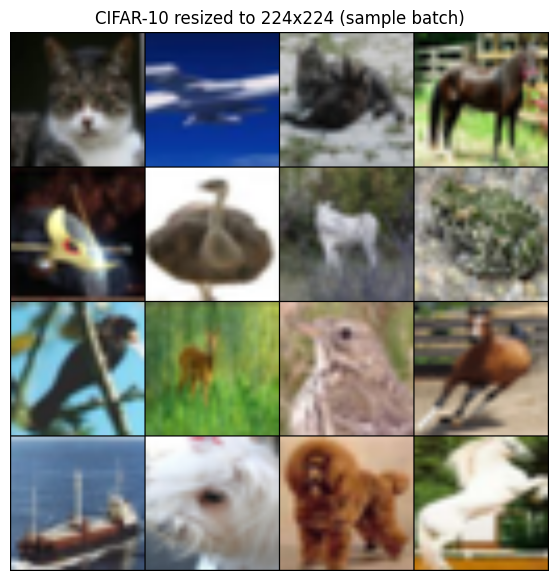

In [6]:
images, labels = next(iter(train_loader))

# Take first 16 images directly
images_vis = images[:16].clamp(0, 1)

fig, ax = plt.subplots(figsize=(7, 7))
grid = torchvision.utils.make_grid(images_vis, nrow=4)
ax.imshow(grid.permute(1, 2, 0))  # CHW -> HWC
ax.set_title("CIFAR-10 resized to 224x224 (sample batch)")
ax.axis("off")
plt.show()

Check classes of first few images

In [7]:
print("Label examples:", [classes[i] for i in labels[:8].tolist()])

Label examples: ['cat', 'airplane', 'cat', 'horse', 'ship', 'bird', 'deer', 'frog']


## Patchify: turning images into patch tokens

ViT splits an image into non-overlapping $P \times P$ patches.
Each patch is flattened and treated like a token.

For an image with shape $[B, C, H, W]$ and patch size $P$, the number of patches is:

$$
N = \left(\frac{H}{P}\right)\left(\frac{W}{P}\right)
$$

and each patch has dimension $C P^2$.

We run patchify on a small batch and print shapes.
For $224 \times 224$ and $P=16$, the number of patches is $N=196$.


In [8]:
image_height, image_width = 224, 224
patch_size = 16
total_patches = (image_height/patch_size) * (image_width/patch_size)
print("Total number of patches", int(total_patches))

Total number of patches 196


Visualize convolution operation her https://ezyang.github.io/convolution-visualizer/

### What `nn.Conv2d` Does

`nn.Conv2d` applies a **sliding window operation** over an input image to produce **learned feature maps**.

At each spatial location, it:
1. Looks at a small region of the input (defined by `kernel_size`)
2. Uses a set of **learned filters** that span **all input channels**
3. Computes weighted sums (+ bias)
4. Outputs one value per filter

Each **output channel** corresponds to **one filter**, so `out_channels` controls how many features are produced.

In the context of Vision Transformers:
- `kernel_size = patch_size`
- `stride = patch_size`

This makes `Conv2d`:
- Split the image into **non-overlapping patches**
- Linearly **project each patch** into a fixed-size embedding vector

Effectively, it performs **patch extraction + linear projection in one operation**.


In [9]:
def patchify(x: torch.Tensor, patch_size = 16):
    print("Input tensor shape (B, C, H, W):", x.shape)

    ''' Convert input pixels to a projection.
    Projection = a learned linear mapping that converts a raw image patch into a fixed-dimensional 
    feature vector suitable for a transformer.
    New vector will not be a raw pixel value but it will be a learned representation.'''

    proj = nn.Conv2d(in_channels=3, out_channels=768,
                     kernel_size=patch_size, stride=patch_size)
    x = proj(x)
    print("After Conv2d patch projection (B, D, H', W'):", x.shape)

    # Flatten spatial grid into patch count
    x = x.flatten(2)
    print("After flattening spatial dims → patches (B, D, N):", x.shape)

    # Transformer expects: batch, sequence_length, embedding_dim
    x = x.transpose(1, 2)
    print("After transpose for transformer input (B, N, D):", x.shape)

    return x

patches = patchify(images, patch_size=patch_size)

Input tensor shape (B, C, H, W): torch.Size([64, 3, 224, 224])
After Conv2d patch projection (B, D, H', W'): torch.Size([64, 768, 14, 14])
After flattening spatial dims → patches (B, D, N): torch.Size([64, 768, 196])
After transpose for transformer input (B, N, D): torch.Size([64, 196, 768])


Check learned representation vector for first patch

In [10]:
patches[0][0][:10]

tensor([ 0.0640,  0.0353,  0.0267, -0.0027,  0.0091,  0.0487, -0.0225,  0.0200,
         0.0152,  0.0348], grad_fn=<SliceBackward0>)

## Patch embedding, class token, and positional embedding

After patchifying the image, each patch vector $\mathbf{x}_i$ is linearly projected
into the model dimension $D$:

$$
\mathbf{z}_i = E \mathbf{x}_i + \mathbf{b}
$$

where  
$\mathbf{x}_i \in \mathbb{R}^{3.P.P}$ is the flattened raw pixel vector of patch $i$,  
$E \in \mathbb{R}^{D \times (3.P.P)}$ is the learned projection matrix,  
$\mathbf{b} \in \mathbb{R}^{D}$ is the bias term, and  
$\mathbf{z}_i \in \mathbb{R}^{D}$ is the resulting patch embedding (token).

This converts image patches into transformer-compatible vectors.

ViT prepends a learnable class token and adds learnable positional embeddings:

$$
\mathbf{Z}_0 = [\mathbf{z}_{\mathrm{cls}}; \mathbf{z}_1; \dots; \mathbf{z}_N] + \mathbf{E}_{\mathrm{pos}}
$$

PyTorch layers already include reasonable default initializations, so we do not manually initialize weights here.


In [11]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_chans: int, embed_dim: int):
        super().__init__()
        assert img_size % patch_size == 0, "img_size must be divisible by patch_size"
        self.num_patches = (img_size // patch_size) ** 2

        # patchify + linear projection in one step
        self.proj = nn.Conv2d(in_channels=in_chans, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.num_patches, embed_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.shape[0]

        x = self.proj(x)                       # [B, D, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)       # [B, N, D]

        # A learnable class token which will be prepended to patch sequences and will be used for final classification
        cls = self.cls_token.expand(B, -1, -1) # [B, 1, D]
        x = torch.cat([cls, x], dim=1)         # [B, 1+N, D]

        x = x + self.pos_embed[:, : x.size(1)]
        return x

pe = PatchEmbedding(img_size=img_size, patch_size=patch_size, in_chans=3, embed_dim=768)

with torch.inference_mode():
    tok = pe(images)
print("PatchEmbedding output:", tok.shape)  # expected [64, 197, 768]

print("Initail token values", tok[0][0][:10])
print("Other token values", tok[1][1][:10])

PatchEmbedding output: torch.Size([64, 197, 768])
Initail token values tensor([ 3.4733,  3.3663,  3.2882, -2.4292, -2.1671,  1.3012, -0.2064, -0.6599,
         0.1871, -0.0709])
Other token values tensor([-0.0531,  1.5897,  0.2410, -0.9334,  0.3775, -1.5351, -0.3615,  0.3781,
        -0.5024,  1.1210])


## Sclaed Dot Product Self Attention

Self-attention allows each token in a sequence to dynamically gather information
from all other tokens based on relevance.

Each token is represented by three vectors:
$$
\text{Query (Q): what I am looking for}
$$
$$
\text{Key (K): what I contain}
$$
$$
\text{Value (V): the information I provide}
$$

<img src="assets/multi-head-attention.png" alt="Self & multi-head attention" width="800" height="500">


### Similarity computation
To measure how relevant token $j$ is to token $i$, we compute a dot product:
$$
\text{score}_{ij} = \mathbf{q}_i \cdot \mathbf{k}_j
$$

This produces a similarity score between every query and key.

### Scaling
As the dimensionality $d_k$ increases, dot products grow in magnitude.
To keep values numerically stable, scores are scaled:
$$
\text{scaled\_score}_{ij} = \frac{\mathbf{q}_i \cdot \mathbf{k}_j}{\sqrt{d_k}}
$$

### Attention weights
Scores are converted into probabilities using softmax:
$$
\alpha_{ij} =
\frac{\exp(\text{scaled\_score}_{ij})}
{\sum_{j'} \exp(\text{scaled\_score}_{ij'})}
$$

Each row of $\alpha$ sums to 1, representing how much attention token $i$
pays to every other token.

### Contextualized representation
The output for token $i$ is a weighted sum of value vectors:
$$
\mathbf{o}_i = \sum_{j} \alpha_{ij} \mathbf{v}_j
$$

This allows each token to incorporate information from the entire sequence.

### Matrix form
For all tokens at once, attention is written as:
$$
\mathrm{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) =
\mathrm{softmax}\left(
\frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d_k}}
\right)\mathbf{V}
$$

In [12]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout: float = 0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        d_k = q.shape[-1]

        # k.transpose(-2, -1) turns [B, h, N, d] into [B, h, d, N] so we can do Q @ K^T
        scores = q @ k.transpose(-2, -1)  # [B, h, N, N]
        scores = scores / math.sqrt(d_k)  # scaling keeps scores in a good numeric range

        attn = F.softmax(scores, dim=-1)  # attention weights over keys
        attn = self.dropout(attn)

        out = attn @ v  # weighted sum of values
        return out, attn

attn_layer = ScaledDotProductAttention(dropout=0.0)
q = torch.randn(64, 12, 197, 64)
k = torch.randn(64, 12, 197, 64)
v = torch.randn(64, 12, 197, 64)
with torch.inference_mode():
    out, attn = attn_layer(q, k, v)
print("ScaledDotProductAttention out:", out.shape)
print("ScaledDotProductAttention attn:", attn.shape)


ScaledDotProductAttention out: torch.Size([64, 12, 197, 64])
ScaledDotProductAttention attn: torch.Size([64, 12, 197, 197])


## Multi-Head Self-Attention

Multi-head self-attention allows a model to look at the same sequence
from multiple perspectives at the same time.

Instead of performing attention once in a single space of dimension $D$,
the model splits the embedding into $h$ smaller subspaces, each of size
$d = D / h$.

Each head learns its own way of relating tokens.

---

### Why multiple heads?

A single attention head can only focus on one type of relationship.
Multiple heads allow the model to capture different patterns simultaneously,
such as local structure, long-range dependencies, or semantic similarity.

---

### Projection into heads

Each token embedding $x \in \mathbb{R}^D$ is linearly projected into
queries, keys, and values, then split into heads:

$$
Q, K, V \in \mathbb{R}^{B \times h \times N \times d}
$$

Each head attends independently in its own subspace.

---

### Attention per head

For a single head, attention is computed as:

$$
\mathrm{Attention}(Q_h, K_h, V_h)
=
\mathrm{softmax}\left(
\frac{Q_h K_h^\top}{\sqrt{d}}
\right)V_h
$$

This allows each token to selectively gather information
from all other tokens.

---

### Concatenation and mixing

The outputs of all heads are concatenated and projected back
to the model dimension:

$$
\mathrm{MHSA}(X)
=
\mathrm{Concat}(\text{head}_1, \dots, \text{head}_h) W_O
$$

This final projection mixes information across heads and produces
the updated token representations.

---

### Key idea

Multi-head attention enables parallel, diverse views of the same data,
making attention more expressive than a single-head mechanism.


In [13]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, attn_dropout: float = 0.0, proj_dropout: float = 0.0):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, 3 * embed_dim)  # one projection for Q, K, V
        self.attn = ScaledDotProductAttention(dropout=attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)     # output projection
        self.proj_dropout = nn.Dropout(proj_dropout)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        B, N, D = x.shape

        qkv = self.qkv(x)              # [B, N, 3D]
        q, k, v = qkv.chunk(3, dim=-1) # each is [B, N, D]

        q = q.view(B, N, self.num_heads, self.head_dim)
        k = k.view(B, N, self.num_heads, self.head_dim)
        v = v.view(B, N, self.num_heads, self.head_dim)

        # transpose moves the head dimension before sequence length so attention is computed per head
        q = q.transpose(1, 2)  # [B, h, N, d]
        k = k.transpose(1, 2)  # [B, h, N, d]
        v = v.transpose(1, 2)  # [B, h, N, d]

        out, attn = self.attn(q, k, v)

        # merge heads back to D
        out = out.transpose(1, 2).contiguous()  # contiguous makes memory layout compatible with view
        out = out.view(B, N, D)

        out = self.proj(out)
        out = self.proj_dropout(out)
        return out, attn

mhsa = MultiHeadSelfAttention(embed_dim=768, num_heads=12)
x = torch.randn(64, 197, 768)
with torch.inference_mode():
    y, a = mhsa(x)
print("MultiHeadSelfAttention out:", y.shape)
print("MultiHeadSelfAttention attn:", a.shape)


MultiHeadSelfAttention out: torch.Size([64, 197, 768])
MultiHeadSelfAttention attn: torch.Size([64, 12, 197, 197])


## MLP in the Transformer Encoder

After self-attention mixes information across tokens, the MLP transforms
each token **independently**.

For a token embedding $\mathbf{x} \in \mathbb{R}^D$, the MLP computes:
$$
\mathrm{MLP}(\mathbf{x}) = \mathbf{W}_2 \, \mathrm{GELU}(\mathbf{W}_1 \mathbf{x})
$$

The first layer expands the dimension ($D \rightarrow 4D$),
the non-linearity increases expressive power,
and the second layer projects back to $D$.

Attention enables **token interaction**,
while the MLP performs **per-token computation**.


In [14]:
class MLP(nn.Module):
    def __init__(self, embed_dim: int, mlp_ratio: float = 4.0, dropout: float = 0.0):
        super().__init__()
        hidden_dim = int(embed_dim * mlp_ratio)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.drop = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

mlp = MLP(embed_dim=768, mlp_ratio=4.0, dropout=0.0)
x = torch.randn(64, 197, 768)
with torch.inference_mode():
    y = mlp(x)
print("MLP out:", y.shape)


MLP out: torch.Size([64, 197, 768])


## Transformer encoder block

A ViT encoder block uses LayerNorm and residual connections:

$$
\mathbf{y} = \mathbf{x} + \mathrm{MHA}(\mathrm{LN}(\mathbf{x}))
$$

$$
\mathbf{z} = \mathbf{y} + \mathrm{MLP}(\mathrm{LN}(\mathbf{y}))
$$


In [15]:
class EncoderBlock(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, mlp_ratio: float = 4.0,
                 attn_dropout: float = 0.0, dropout: float = 0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, attn_dropout=attn_dropout, proj_dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_ratio=mlp_ratio, dropout=dropout)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        y, attn = self.attn(self.norm1(x))
        x = x + y
        y = self.mlp(self.norm2(x))
        x = x + y
        return x, attn

blk = EncoderBlock(embed_dim=768, num_heads=12, mlp_ratio=4.0, dropout=0.0)
x = torch.randn(64, 197, 768)
with torch.no_grad():
    y, a = blk(x)
print("EncoderBlock out:", y.shape)
print("EncoderBlock attn:", a.shape)


EncoderBlock out: torch.Size([64, 197, 768])
EncoderBlock attn: torch.Size([64, 12, 197, 197])


## MLP Head for Classification (ViT)

The classification head operates on the final `[CLS]` token,
which serves as a global representation of the image.

When `representation_size = None`, the head is a single linear layer:
$$
\mathbf{z} = W \mathbf{c} + \mathbf{b}
$$
where $\mathbf{c} \in \mathbb{R}^{768}$ is the CLS token
and $\mathbf{z}$ are class logits.

If `representation_size` is specified, an additional projection is used:
$$
\mathbf{z} = W_2 \, \tanh(W_1 \mathbf{c})
$$

The output logits are passed to a softmax loss for classification.

In [16]:
class MLPHead(nn.Module):
    def __init__(self, embed_dim: int, num_classes: int, representation_size: Optional[int] = None):
        super().__init__()
        self.representation_size = representation_size

        if representation_size is None:
            self.pre_logits = nn.Identity()
            self.head = nn.Linear(embed_dim, num_classes)
        else:
            self.pre_logits = nn.Linear(embed_dim, representation_size)
            self.act = nn.Tanh()
            self.head = nn.Linear(representation_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pre_logits(x)
        if self.representation_size is not None:
            x = self.act(x)
        x = self.head(x)
        return x


head = MLPHead(embed_dim=768, num_classes=10, representation_size=None)
cls = torch.randn(64, 768)
with torch.no_grad():
    logits = head(cls)
print("MLPHead logits:", logits.shape)

MLPHead logits: torch.Size([64, 10])


## Vision Transformer (ViT-Base/16)

This model uses:
- patch size $16$
- embedding dimension $768$
- 12 encoder blocks
- 12 attention heads
- MLP ratio $4$

The forward pass returns logits with shape $[B, C]$ where C = number of classes.


In [17]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size: int = 224,
        patch_size: int = 16,
        in_chans: int = 3,
        num_classes: int = 10,
        embed_dim: int = 768,
        depth: int = 12,
        num_heads: int = 12,
        mlp_ratio: float = 4.0,
        attn_dropout: float = 0.0,
        dropout: float = 0.1,
        representation_size: Optional[int] = None,
    ):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        self.pos_drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([
            EncoderBlock(embed_dim, num_heads, mlp_ratio, attn_dropout=attn_dropout, dropout=dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = MLPHead(embed_dim, num_classes, representation_size=representation_size)

    def forward(self, x: torch.Tensor, return_attn: bool = False):
        x = self.patch_embed(x) # [B,197,768] = [batch, number of patches, embedding dim]
        x = self.pos_drop(x)

        attn_maps = []
        for blk in self.blocks:
            x, attn = blk(x)
            attn_maps.append(attn)

        x = self.norm(x)
        cls_token = x[:, 0] #[B, 768]
        logits = self.head(cls_token) # [B, number of classes]

        if return_attn:
            return logits, attn_maps
        return logits

vit = VisionTransformer(img_size=img_size, patch_size=patch_size, num_classes=10).to(device)
xb, _ = next(iter(train_loader))
with torch.no_grad():
    logits = vit(xb.to(device))
print("VisionTransformer logits:", logits.shape)


VisionTransformer logits: torch.Size([64, 10])


## Parameter count

We report total parameters and trainable parameters, and also show the count in millions.


In [18]:
trainable_params = sum(p.numel() for p in vit.parameters() if p.requires_grad)
print(f"Trainable parameters (millions): {trainable_params/1e6:.2f}M")


Trainable parameters (millions): 85.81M


## Accuracy function

Accuracy is the fraction of correct predictions computed from logits using $\arg\max$.


In [19]:
def accuracy(logits: torch.Tensor, targets: torch.Tensor) -> float:
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()


## Training for 2 epochs

Important training operations:
- Forward pass: compute logits from inputs.
- `loss.backward()`: compute gradients for all parameters.
- `optimizer.step()`: update parameters using gradients.
- Scheduler: update learning rate over time.


In [20]:
def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer, criterion, epoch: int) -> float:
    model.train()
    running_loss = 0.0

    for step, (x, y) in enumerate(loader):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)  # clears old gradients
        logits = model(x)                      # forward pass
        loss = criterion(logits, y)            # compute loss
        loss.backward()                        # backward pass computes gradients
        optimizer.step()                       # update parameters

        running_loss += loss.item()

        if (step + 1) % 50 == 0:
            print(f"Epoch {epoch} Step {step+1}/{len(loader)} Train Loss {loss.item():.4f}")

    return running_loss / len(loader)


In [21]:
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader, criterion) -> Tuple[float, float]:
    model.eval()
    total_loss = 0.0
    total_acc = 0.0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item()
        total_acc += accuracy(logits, y)

    return total_loss / len(loader), total_acc / len(loader)


## Optimizer, scheduler, and run training

- AdamW updates parameters using adaptive moments and weight decay.
- CosineAnnealingLR changes the learning rate using a cosine schedule across epochs.

We train for 2 epochs and record metrics.


In [22]:
from time import time

model = vit
lr = 3e-4
weight_decay = 0.05
epochs = 7

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

history = {"train_loss": [], "test_loss": [], "test_acc": []}

start = time()
for epoch in range(1, epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    scheduler.step()

    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)

    current_lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch}: train_loss={train_loss:.4f} test_loss={test_loss:.4f} test_acc={test_acc*100:.2f}% lr={current_lr:.6f}")

print(f"Done in {(time()-start)/60:.2f} minutes")


Epoch 1 Step 50/782 Train Loss 2.2918
Epoch 1 Step 100/782 Train Loss 2.3287
Epoch 1 Step 150/782 Train Loss 2.1612
Epoch 1 Step 200/782 Train Loss 1.9762
Epoch 1 Step 250/782 Train Loss 2.0850
Epoch 1 Step 300/782 Train Loss 2.0450
Epoch 1 Step 350/782 Train Loss 1.8577
Epoch 1 Step 400/782 Train Loss 1.7627
Epoch 1 Step 450/782 Train Loss 1.9834
Epoch 1 Step 500/782 Train Loss 1.8642
Epoch 1 Step 550/782 Train Loss 1.8254
Epoch 1 Step 600/782 Train Loss 1.7438
Epoch 1 Step 650/782 Train Loss 1.9035
Epoch 1 Step 700/782 Train Loss 1.7858
Epoch 1 Step 750/782 Train Loss 1.7277
Epoch 1: train_loss=1.9896 test_loss=1.7383 test_acc=40.37% lr=0.000285
Epoch 2 Step 50/782 Train Loss 1.5706
Epoch 2 Step 100/782 Train Loss 1.7925
Epoch 2 Step 150/782 Train Loss 1.7180
Epoch 2 Step 200/782 Train Loss 1.8224
Epoch 2 Step 300/782 Train Loss 1.9090
Epoch 2 Step 350/782 Train Loss 1.6738
Epoch 2 Step 400/782 Train Loss 1.6904
Epoch 2 Step 450/782 Train Loss 1.6367
Epoch 2 Step 500/782 Train Loss 1

## Visualize training curves

Plot loss and accuracy over epochs.


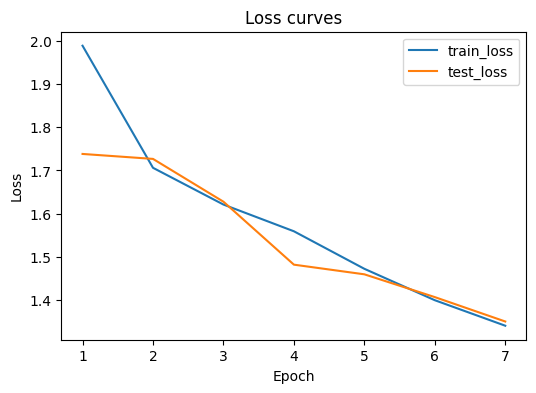

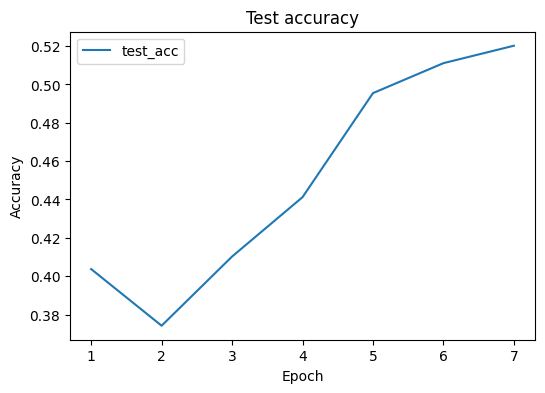

In [23]:
epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(6, 4))
plt.plot(list(epochs_range), history["train_loss"], label="train_loss")
plt.plot(list(epochs_range), history["test_loss"], label="test_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curves")
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(list(epochs_range), history["test_acc"], label="test_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Test accuracy")
plt.show()


## Prediction helper and sanity check

We convert logits to predicted labels using $\arg\max$.


In [24]:
@torch.no_grad()
def predict_batch(model: nn.Module, x: torch.Tensor) -> torch.Tensor:
    model.eval()
    logits = model(x)
    return logits.argmax(dim=1)


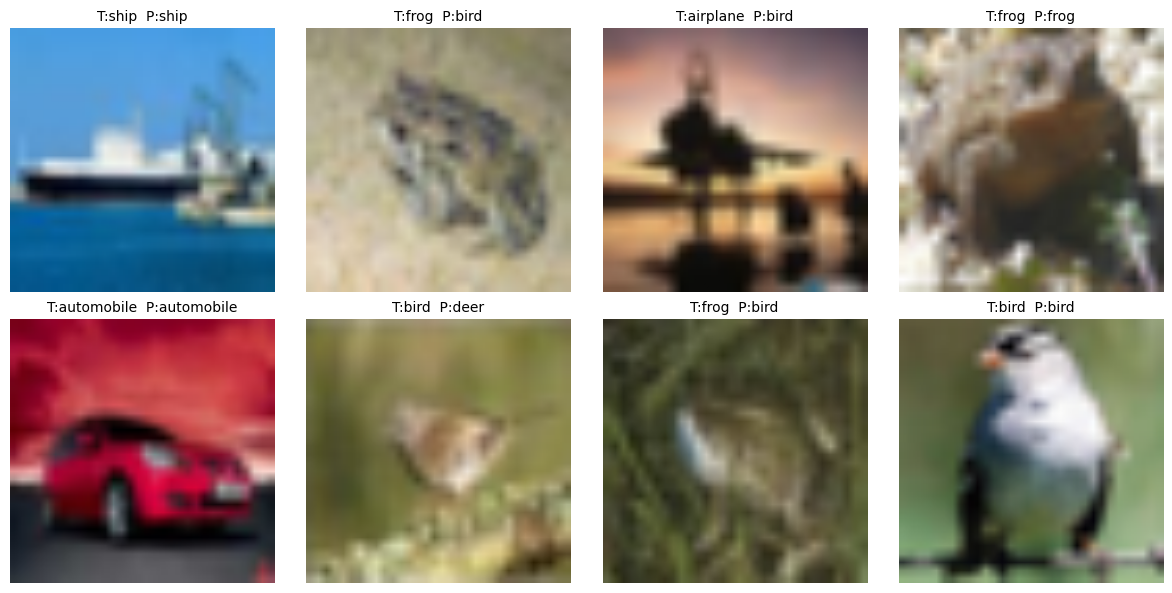

In [25]:
# Grab a batch
images, labels = next(iter(test_loader))
images, labels = images.to(device)[:8], labels[:8]  # keep labels on device

# Predict
preds = predict_batch(model, images).cpu()

# Plot (images already in [0,1] from ToTensor)
images_plot = images.cpu().clamp(0, 1)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images_plot[i].permute(1, 2, 0))  # CHW -> HWC
    ax.set_title(f"T:{classes[labels[i]]}  P:{classes[preds[i]]}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

## Save trained model and load

In [26]:
# save final trained model weights
torch.save(model.state_dict(), "vit_final.pth")

In [29]:
def load_vit_checkpoint(path: str, device, img_size=224, patch_size=16, num_classes=10):
    model = VisionTransformer(
        img_size=img_size,
        patch_size=patch_size,
        num_classes=num_classes,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        attn_dropout=0.0,
        dropout=0.1,
        representation_size=None,
    ).to(device)

    sd = torch.load(path, map_location=device)
    model.load_state_dict(sd, strict=True)
    model.eval()
    return model

trained_model = load_vit_checkpoint("vit_final.pth", device)

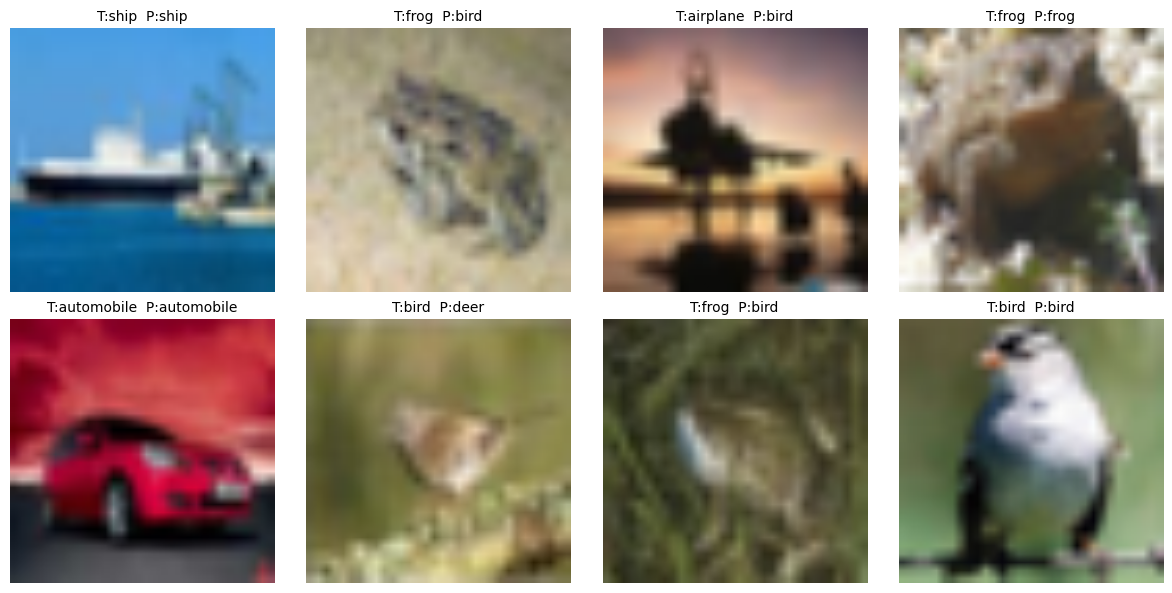

In [33]:
# Predict
preds = predict_batch(trained_model, images).cpu()

# Plot (images already in [0,1] from ToTensor)
images_plot = images.cpu().clamp(0, 1)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images_plot[i].permute(1, 2, 0))  # CHW -> HWC
    ax.set_title(f"T:{classes[labels[i]]}  P:{classes[preds[i]]}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()